## OCR 결과 추출기
학습한 유니코드 결과를 로컬에서 OCR 모델에 통과시켜 파일로 출력, 이후 사용  
ChatGPT 사용하여 주석 및 오류 수정

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf

# === 설정 ===
MODEL_PATH = "./runs_MobileNetV2/final.keras"
INPUT_DIR  = "/home/voxfish_ljy$/virtual/Unicodes"     # unicode_tensors_N.npy가 들어 있는 폴더
OUTPUT_DIR = "/home/voxfish_ljy$/virtual/Unicodes"    # unicode_results_N.npy를 저장할 폴더
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 필요한 custom_objects 정의 ---
L_SLICE = slice(0, 19)
V_SLICE = slice(19, 40)
T_SLICE = slice(40, 68)

def hangul_loss(y_true, logits):
    cho  = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, L_SLICE], logits=logits[:, L_SLICE])
    jung = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, V_SLICE], logits=logits[:, V_SLICE])
    jong = tf.nn.softmax_cross_entropy_with_logits(labels=y_true[:, T_SLICE], logits=logits[:, T_SLICE])
    return cho + jung + jong

def acc_first(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true[:, L_SLICE], -1),
                                           tf.argmax(y_pred[:, L_SLICE], -1)), tf.float32))
def acc_middle(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true[:, V_SLICE], -1),
                                           tf.argmax(y_pred[:, V_SLICE], -1)), tf.float32))
def acc_last(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true[:, T_SLICE], -1),
                                           tf.argmax(y_pred[:, T_SLICE], -1)), tf.float32))
def acc_joint(y_true, y_pred):
    l_ok = tf.equal(tf.argmax(y_true[:, L_SLICE], -1), tf.argmax(y_pred[:, L_SLICE], -1))
    v_ok = tf.equal(tf.argmax(y_true[:, V_SLICE], -1), tf.argmax(y_pred[:, V_SLICE], -1))
    t_ok = tf.equal(tf.argmax(y_true[:, T_SLICE], -1), tf.argmax(y_pred[:, T_SLICE], -1))
    return tf.reduce_mean(tf.cast(l_ok & v_ok & t_ok, tf.float32))

# --- 모델 로드 ---
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={
        "hangul_loss": hangul_loss,
        "acc_first": acc_first,
        "acc_middle": acc_middle,
        "acc_last": acc_last,
        "acc_joint": acc_joint,
    }
)
print("✅ Model loaded.")

# --- 입력 파일 목록 ---
input_files = sorted(glob.glob(os.path.join(INPUT_DIR, "combined_unicode_tensors_*.npy")))
if not input_files:
    raise FileNotFoundError("입력 폴더에 combined_unicode_tensors_*.npy 파일이 없습니다.")

for f_in in input_files:
    base = os.path.basename(f_in)                   # unicode_tensors_N.npy
    f_out = base.replace("combined_unicode_tensors_", "combined_unicode_results_")
    out_path = os.path.join(OUTPUT_DIR, f_out)

    # 입력 데이터 로드
    X = np.load(f_in)                               # shape: (N, 128,128,1)
    if X.ndim == 3:
        X = np.expand_dims(X, -1)
    X = X.astype(np.float32)
    if np.max(X) > 1.5:
        X /= 255.0                                  # 정규화

    print(f"▶ Predicting {f_in} -> {out_path} (shape={X.shape})")

    # 모델 예측
    preds = model.predict(X, batch_size=256, verbose=1)  # (N,68)

    # 결과 저장
    np.save(out_path, preds.astype(np.float32))
    print(f"✅ Saved {out_path}\n")

print("🎉 모든 파일 처리 완료!")

✅ Model loaded.
▶ Predicting /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_tensors_0.npy -> /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_0.npy (shape=(16384, 128, 128, 1))
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
✅ Saved /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_0.npy

▶ Predicting /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_tensors_1.npy -> /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_1.npy (shape=(16384, 128, 128, 1))
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step
✅ Saved /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_1.npy

▶ Predicting /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_tensors_10.npy -> /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_10.npy (shape=(16384, 128, 128, 1))
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
✅ Saved /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_results_10.npy

▶ Predicting /home/voxfish_ljy$/virtual/Unicodes/combined_unicode_tensors_11.npy -> /home/voxfis

## OCR 테스트 기능
랜덤한 유니코드가 잘 출력되고, OCR이 기능하는지 확인  
전체 코드 GPT를 이용하여 생성

[Shard 10, Index 920]
입력 이미지:


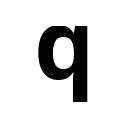


예측된 초성/중성/종성 (argmax 기준): ㅇㅣ


In [142]:
import os, glob, random
import numpy as np
import tensorflow as tf
from IPython.display import Image, display

# ===== 경로 설정(필요에 맞게 수정) =====
TENSOR_DIR = r"/home/voxfish_ljy$/virtual/Unicodes"   # unicode_tensors_*.npy 있는 폴더
RESULT_DIR = r"/home/voxfish_ljy$/virtual/Unicodes"   # unicode_results_*.npy 있는 폴더

# 68차원 벡터를 초/중/종성으로 해석하고 싶을 때만 사용 (선택)
L_SLICE = slice(0, 19)
V_SLICE = slice(19, 40)
T_SLICE = slice(40, 68)

CHOS = ["ㄱ","ㄲ","ㄴ","ㄷ","ㄸ","ㄹ","ㅁ","ㅂ","ㅃ","ㅅ","ㅆ","ㅇ","ㅈ","ㅉ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]
JUNS = ["ㅏ","ㅐ","ㅑ","ㅒ","ㅓ","ㅔ","ㅕ","ㅖ","ㅗ","ㅘ","ㅙ","ㅚ","ㅛ","ㅜ","ㅝ","ㅞ","ㅟ","ㅠ","ㅡ","ㅢ","ㅣ"]
JONGS = ["","ㄱ","ㄲ","ㄳ","ㄴ","ㄵ","ㄶ","ㄷ","ㄹ","ㄺ","ㄻ","ㄼ","ㄽ","ㄾ","ㄿ","ㅀ","ㅁ","ㅂ","ㅄ","ㅅ","ㅆ","ㅇ","ㅈ","ㅊ","ㅋ","ㅌ","ㅍ","ㅎ"]

def decode_LVT(vec):
    """68차원 벡터를 (초성, 중성, 종성) 문자로 대략 해석 (선택 기능)"""
    l_idx = np.argmax(vec[L_SLICE])
    v_idx = np.argmax(vec[V_SLICE])
    t_idx = np.argmax(vec[T_SLICE])
    return CHOS[l_idx], JUNS[v_idx], JONGS[t_idx]


def show_png_from_tensor(x):
    """
    (H,W) 또는 (H,W,1) 텐서를 Jupyter에 이미지로 표시
    x: numpy array, 값 범위가 0/1 또는 0~255라고 가정
    """
    arr = x
    if arr.ndim == 2:
        arr = arr[..., None]      # (H,W,1)로
    # 값 스케일 맞춰서 uint8로
    if arr.max() <= 1.0:
        arr = (arr * 255).astype(np.uint8)
    else:
        arr = arr.astype(np.uint8)
    png_bytes = tf.io.encode_png(tf.constant(arr)).numpy()
    display(Image(data=png_bytes))


def check_random_pair(tensor_dir=TENSOR_DIR, result_dir=RESULT_DIR):
    # 1) 파일 목록 수집
    tensor_files = sorted(glob.glob(os.path.join(tensor_dir, "unicode_tensors_*.npy"))) or sorted(glob.glob(os.path.join(tensor_dir, "combined_unicode_tensors_*.npy")))
    result_files = sorted(glob.glob(os.path.join(result_dir, "unicode_results_*.npy"))) or sorted(glob.glob(os.path.join(tensor_dir, "combined_unicode_results_*.npy")))

    assert len(tensor_files) > 0, "unicode_tensors_*.npy 파일이 없습니다."
    assert len(tensor_files) == len(result_files), "tensors와 results 샤드 개수가 다릅니다."

    # 2) 랜덤 샤드 선택
    shard_idx = random.randint(0, len(tensor_files) - 1)
    X = np.load(tensor_files[shard_idx], mmap_mode="r")   # (N,128,128,1) 또는 (N,128,128)
    R = np.load(result_files[shard_idx], mmap_mode="r")   # (N,68)

    assert X.shape[0] == R.shape[0], f"샤드 {shard_idx}의 샘플 수가 다릅니다: X={X.shape[0]}, R={R.shape[0]}"

    # 3) 랜덤 인덱스 선택
    i = random.randint(0, X.shape[0] - 1)
    x = X[i]
    vec = R[i]

    # 4) 입력 이미지 표시
    print(f"[Shard {shard_idx}, Index {i}]")
    print("입력 이미지:")
    show_png_from_tensor(x)

    # 선택: 초/중/종성으로 해석해서 보기 (vec이 그런 구조라면)
    try:
        l, v, t = decode_LVT(vec)
        print(f"\n예측된 초성/중성/종성 (argmax 기준): {l}{v}{t}")
    except Exception as e:
        print("\ndecode_LVT에서 오류 발생 (벡터 구조가 다를 수 있음):", e)

    return x, vec


# 실행 예시 (몇 번 돌려보면서 확인)
_ = check_random_pair()